# Optimal transport distance between 2D densities 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.integrate import simps
from scipy.sparse import diags, csr_matrix, eye, kron, lil_matrix, coo_matrix, vstack, hstack
from scipy.sparse.linalg import spsolve
from scipy.interpolate import RegularGridInterpolator

## Define densities (or images)

In [2]:
def _meshgrid(n):
    x = np.linspace(0, 1, n)
    x1, x2 = np.meshgrid(x, x, indexing='xy')
    return x, x1, np.flipud(x2)  

In [3]:
row = 128

x, x1, x2 = _meshgrid(row)

source = np.exp(-((x1-0.25)**2 + (x2-0.75)**2)/0.01)
target = np.exp(-((x1-0.75)**2 + (x2-0.25)**2)/0.01)

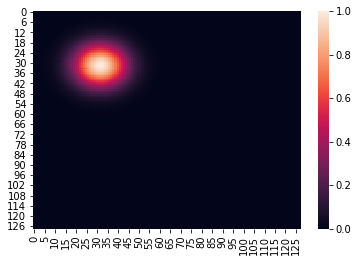

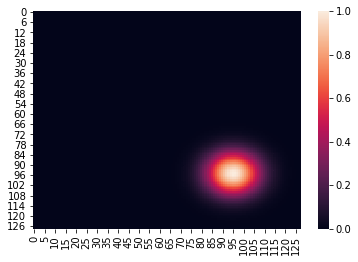

In [4]:
sns.heatmap(source)
plt.show()
sns.heatmap(target)
plt.show()

# Optimal transport solver

Numerical Solution to the Monge's optimal transport problem, which is a 2D Monge-Ampere PDE where the densities are images.

This is solved in the domain $X = [0,1] \times [0,1]$

In [5]:
# Solving using Newton's method. Define maximum number of iterations in case it doesn't converge.
# Set error tolerance. 
# Add Small constant to density as Monge's problem is defined for strictly positive densities

max_iterations = 100
tol = 1e-10
epsilon = 1 

row, col = source.shape
dx = 1 / (source.shape[0] - 1) # make no. of pixels the resolution

## Normalise densities such that $\int f(x) dx = \int g(y) dy = 1$

Also add a small constant $\epsilon$ to ensure densities are non-zero. 

In [6]:
def _normalise(density, eps, dx):
    density += eps
    integrand = np.trapz(np.trapz(density, dx=dx), dx=dx)
    return density / integrand

In [7]:
source_normalised = _normalise(source, eps=epsilon, dx=dx)
G = _normalise(target, eps=epsilon, dx=dx)

F = source_normalised.flatten()

G_y1, G_y2 = np.gradient(G, dx)
G_y2 = -G_y2 

# Turn discrete densities (like images) to surface by simple interpolation

In [8]:
# Turn image into a surface using spine interpolation 

G_int = RegularGridInterpolator((x,x), G)
Gy1_int = RegularGridInterpolator((x,x), G_y1)
Gy2_int = RegularGridInterpolator((x,x), G_y2)

# Set up derivative matrices using Kronecker product. 

In [9]:
def _dx(m):
    diagonals = [np.ones(m-1), -np.ones(m-1)]
    diagonals1 = [np.ones(m-1), -2*np.ones(m), np.ones(m-1)]
    dx = diags(diagonals, [-1, 1]).toarray()
    dxx = diags(diagonals1, [-1, 0, 1]).toarray()
    dx[0,1], dx[-1,-2] = 0, 0       
    dxx[0,1], dxx[-1,-2] = 2, 2
    return csr_matrix(-dx), csr_matrix(dxx)

In [10]:
def _derivative_matrices(m):
    dx1 = kron(_dx(m)[0], eye(m))
    dx2 = -kron(eye(m), _dx(m)[0])
    d2x1 = kron(_dx(m)[1], eye(m))
    d2x2 = kron(eye(m), _dx(m)[1])
    dx1x2 = -kron(_dx(m)[0], _dx(m)[0])   
    return dx1, dx2, d2x1, d2x2, dx1x2

In [11]:
def _helpers(m):
    diagonals = np.ones(m-1)
    right = diags(diagonals, 1).toarray()
    left = diags(diagonals, -1).toarray()
    right[0,1] = 2
    left[-1, -2] = 2
    return csr_matrix(right), csr_matrix(left)

In [12]:
dx1, dx2, dx1x1, dx2x2, dx1x2 = _derivative_matrices(row)

R, L = _helpers(row) # for later setting up linear system W*u = b

d1 = lil_matrix((row**2, col**2))
d2 = lil_matrix((row**2, col**2))
d3 = lil_matrix((row**2, col**2))
d4 = lil_matrix((row**2, col**2))
d5 = lil_matrix((row**2, col**2))
d6 = lil_matrix((row**2, col**2))

# Iteratively solve using Newton's method

In [13]:
error = 10 # set inital error and iteration. Set up solution vector $u(x1,x2)$

max_iterations = 20
iteration = 0

u = np.zeros(row*col)

# %% Nonlinear solver using damped Newton iteration

while (iteration < max_iterations) & (abs(error) > tol):
    # take derivatives of $u(x1,x2)$
    Ux1 = dx1*u/(2*dx)
    Ux2 = dx2*u/(2*dx) 
    Ux1x1 = dx1x1*u/dx**2 
    Ux2x2 = dx2x2*u/dx**2 
    Ux1x2 = dx1x2*u/(4*dx*dx) 
    
    x_Ux1 = x1 - np.reshape(Ux1, [row,col]).T;
    x_Ux2 = x2 - np.reshape(Ux2, [row,col]).T;
    
# Density g(y) and its derivatives

    G = G_int(list(zip(list(1 - x_Ux2.flatten()), list(x_Ux1.flatten()))))
    Gy1 = Gy1_int(list(zip(list(1 - x_Ux2.flatten()), list(x_Ux1.flatten()))))
    Gy2 = Gy2_int(list(zip(list(1 - x_Ux2.flatten()), list(x_Ux1.flatten()))))
    
    A =  1 - Ux1x1 - Ux2x2 - Ux1x2**2 + np.multiply(Ux1x1, Ux2x2)
    B =  Ux2x2 - 1;
    C =  Ux1x1 - 1;
    D = -2*Ux1x2;

# Refer to paper for numerical scheme. 
    
# Error as range between max and min residual
    
    residual = np.multiply((np.multiply((1-Ux1x1), (1-Ux2x2)) - Ux1x2**2), G) - F
    error = np.abs(np.max(residual) - np.min(residual))
    
# Set up sparse matrix for solver
    
    d1.setdiag(B*G/(dx**2) - A*Gy1/(2*dx))
    d2.setdiag(B*G/(dx**2) + A*Gy1/(2*dx))
    d3.setdiag(C*G/(dx**2) - A*Gy2/(2*dx))
    d4.setdiag(C*G/(dx**2) + A*Gy2/(2*dx))
    d5.setdiag(-2*G*(B/(dx**2) + C/(dx**2)))
    d6.setdiag(G*D/(4*dx*dx))
    
    W = d1 * kron(eye(row), R) + d2 * kron(eye(row), L) + d3 * kron(R, eye(row)) + \
    d4 * kron(L, eye(row)) + eye(row*col) * d5 - dx1x2 * d6
    
# system is defined up to a constant. Add extra constraint to give system unique solution
    
    pad1 = csr_matrix(np.ones((1,col**2)))
    pad2 = np.ones((row**2 + 1, 1))
    pad2[-1] = 0
    pad2 = csr_matrix(pad2)
    
    W = vstack((W, pad1))
    W = hstack((W, pad2))
    W = csr_matrix(W)

# Right-hand side                        
                             
    b = np.vstack([(F - G*A).reshape(-1,1), 0])
    b = csr_matrix(b)


# solve the system              

    ew = spsolve(W, b)  

# Update solution and repeat

    u += ew[:-1].flatten()
    print('iteration: ' + str(iteration))
    print('error: ' + str(error))
    iteration += 1

iteration: 0
error: 1.9376040810167483
iteration: 1
error: 0.27646342459733053
iteration: 2
error: 0.30518649708555035
iteration: 3
error: 0.08319690601194507
iteration: 4
error: 0.023764633692258008
iteration: 5
error: 0.005585114819744774
iteration: 6
error: 0.001096115841266454
iteration: 7
error: 0.0003168660396349887
iteration: 8
error: 6.75896028451417e-05
iteration: 9
error: 1.5953843790827982e-05
iteration: 10
error: 3.0032379653155417e-06
iteration: 11
error: 1.092503426503022e-06
iteration: 12
error: 1.7548488029373033e-07
iteration: 13
error: 7.04541068818898e-08
iteration: 14
error: 1.276014693907257e-08
iteration: 15
error: 4.7888516485627974e-09
iteration: 16
error: 1.0552763107796181e-09
iteration: 17
error: 3.139641879812416e-10
iteration: 18
error: 8.624978509175207e-11


In [14]:
Ux1 = dx1*u/(2*dx)
Ux1 = np.reshape(Ux1, [row,col])
Ux2 = dx2*u/(2*dx)
Ux2 = np.reshape(Ux2, [row,col])

# Optimal mapping is s(x) = x - u_x(x), plotted with mesh generation 

sx = x1 - Ux1;
sy = x2 - Ux2;

# Wasserstein metric 

# mapping * source density (T(x)*f(x))

mapped_density = np.multiply(Ux1**2 + Ux2**2, source_normalised)

wasserstein = np.sqrt(np.trapz(np.trapz(mapped_density, dx=dx), dx=dx))

print(wasserstein)

0.028885746382020343


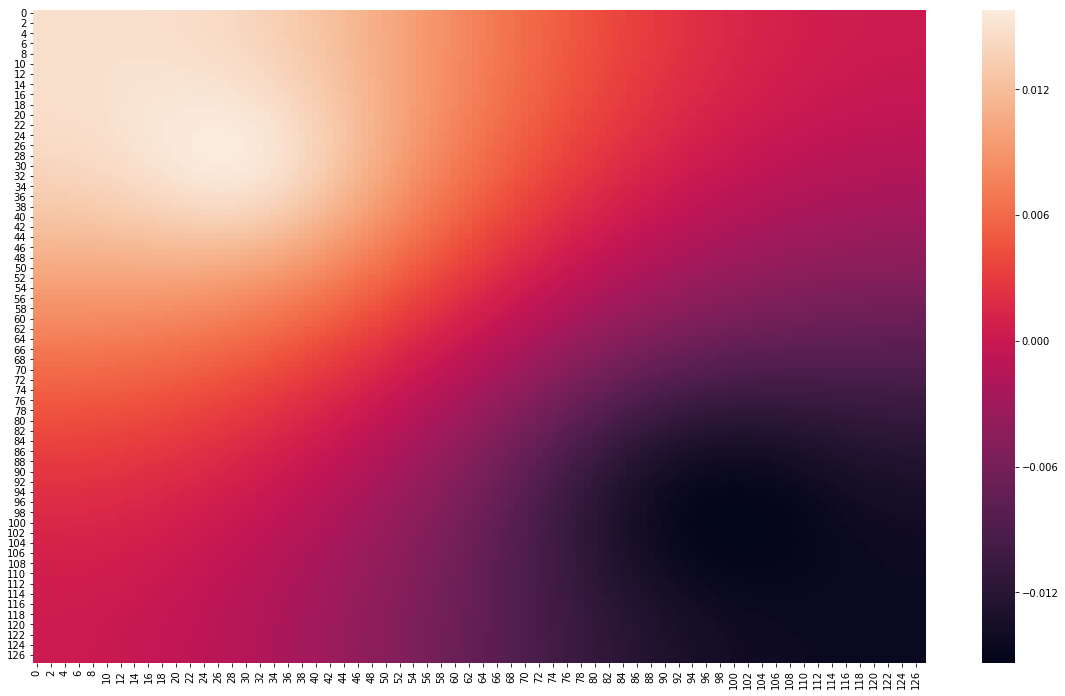

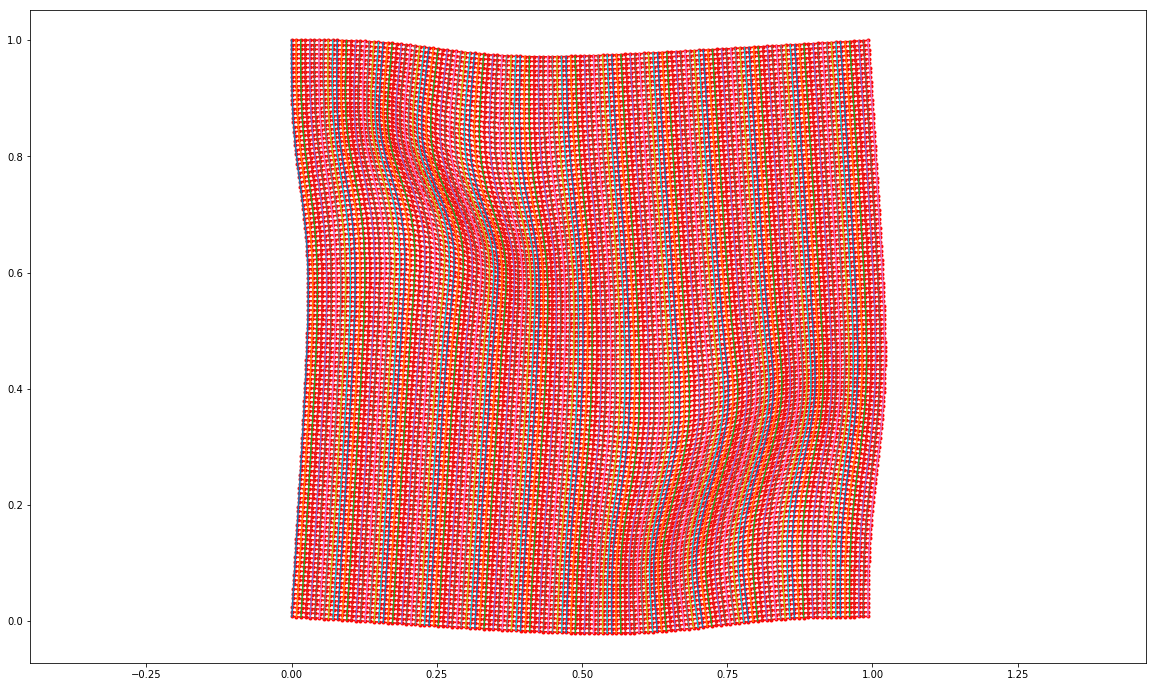

In [15]:
plt.figure(figsize=(20,12))

sns.heatmap(u.reshape(row,col))
plt.show()


spacing = 1
plt.figure(figsize=(20,12))
plt.plot(sx[0:-1:spacing, 0:-1:spacing].T, sy[0:-1:spacing, 0:-1:spacing].T,
         'r.-', sx[0:-1:spacing, 0:-1:spacing], sy[0:-1:spacing, 0:-1:spacing])
plt.axis('equal')
plt.show()